In this notebook we compare two CNN's - a CIFAR10 "simple deep CNN" and an identical CNN that was trained on a version of CIFAR10 that had been attacked with untargeted FGSM. The FGSM was done using an EfficientNet.

First, we see the effect of the adversarial images on the regular CNN vs the adversarially trained CNN.

Next, we evalute the effectiveness of gaussian filtering as a defense against the adversarial images.

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from scipy import ndimage
import random
import helper
import numpy as np
from matplotlib import pyplot as plt
import os
import time

batch_size = 32
num_classes = 10
epochs = 120
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'data')

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using TensorFlow backend.


In [2]:
# loading the regular CIFAR10 CNN

model_name = 'keras_cifar10_trained_model_1.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

model = load_model(os.path.join(save_dir, model_name))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
# loading the adversarially trained CIFAR10 CNN

model_adv_name = 'keras_cifar10_adversarial_trained_model.h5'

x_train_adv = np.load('./data/x_train_adversarial.npy')
y_train_adv = np.load('./data/y_train_adversarial.npy')
x_test_adv = np.load('./data/x_test_adversarial.npy')
y_test_adv = np.load('./data/y_test_adversarial.npy')

model_adv = load_model(os.path.join(save_dir, model_adv_name))

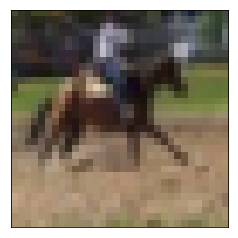

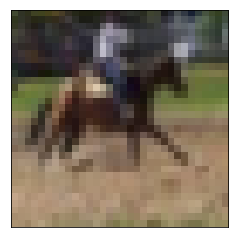

prediction: horse
confidence: 0.936539
prediction (adversarial): horse
confidence: 0.894760


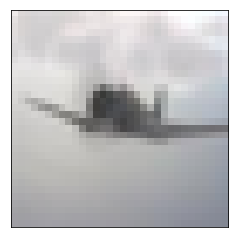

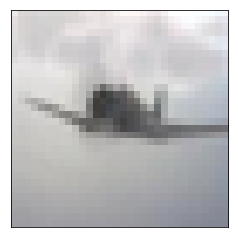

prediction: plane
confidence: 0.911340
prediction (adversarial): plane
confidence: 0.866507


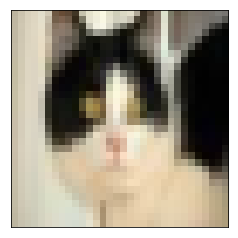

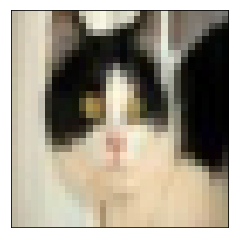

prediction: cat
confidence: 0.943744
prediction (adversarial): cat
confidence: 0.891843


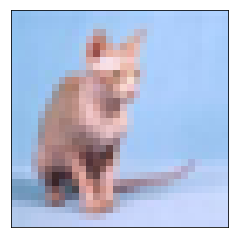

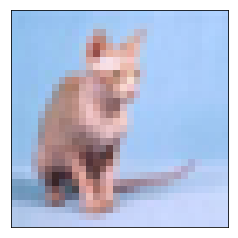

prediction: horse
confidence: 0.360079
prediction (adversarial): horse
confidence: 0.355980


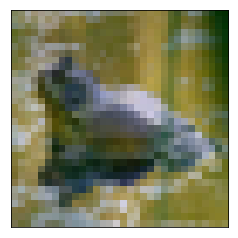

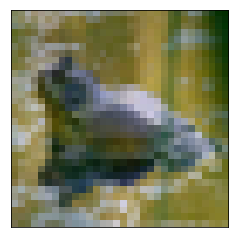

prediction: plane
confidence: 0.366816
prediction (adversarial): plane
confidence: 0.415099


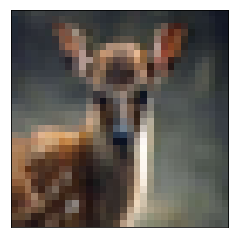

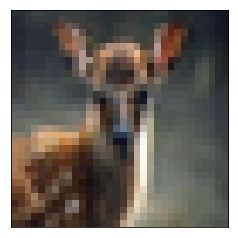

prediction: deer
confidence: 0.961939
prediction (adversarial): deer
confidence: 0.904419


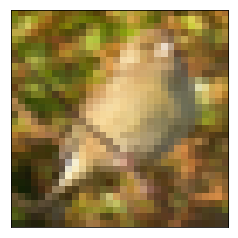

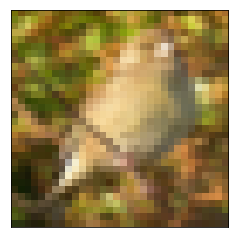

prediction: frog
confidence: 0.477653
prediction (adversarial): frog
confidence: 0.500444


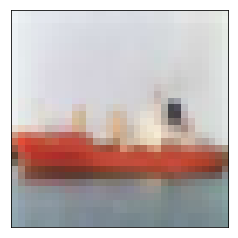

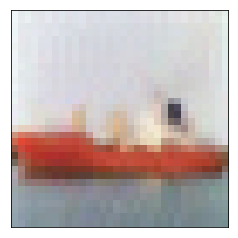

prediction: ship
confidence: 0.998809
prediction (adversarial): ship
confidence: 0.985813


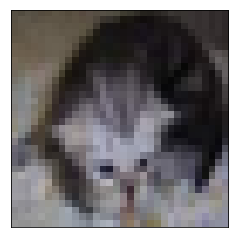

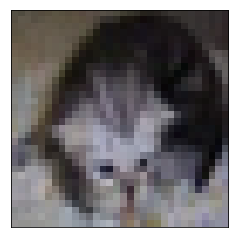

prediction: cat
confidence: 0.719499
prediction (adversarial): cat
confidence: 0.580311


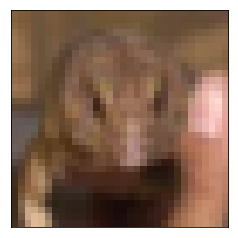

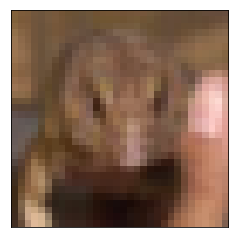

prediction: frog
confidence: 0.696268
prediction (adversarial): frog
confidence: 0.647955


In [4]:
# showing some examples of original vs adversarial images classified by the regular CIFAR10 CNN

for i in range(10):
    idx = random.randint(0,50000)
    helper.plot_image((x_train[idx] * 255).astype('int'))
    helper.plot_image((x_train_adv[idx]*255).astype('int'))
    predictions = model.predict(np.tile(x_train[idx],[1,1,1,1]))
    print("prediction: %s" % (classes[predictions.argmax()]))
    print("confidence: %f" % (predictions.max()))


    predictions = model.predict(np.tile(x_train_adv[idx],[1,1,1,1]))
    print("prediction (adversarial): %s" % (classes[predictions.argmax()]))
    print("confidence: %f" % (predictions.max()))

Initial testing shows that the adversarial images decrease the confidence of the classification, and only misclassify a few images.

In [5]:
# quantifying results

print("CNN score on test set:")
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print("\nCNN score on adversarial test set:")
scores = model.evaluate(x_test_adv, y_test_adv, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print("\nAdversarially trained CNN score on test set:")
scores = model_adv.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print("\nAdversarially trained CNN score on adversarial test set:")
scores = model_adv.evaluate(x_test_adv, y_test_adv, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

CNN score on test set:
10000/10000 [==============================] - 1s 146us/step
Test loss: 0.772959152507782
Test accuracy: 0.7545

CNN score on adversarial test set:
50000/50000 [==============================] - 6s 129us/step
Test loss: 0.6382757876396179
Test accuracy: 0.79604

Adversarially trained CNN score on test set:
10000/10000 [==============================] - 1s 141us/step
Test loss: 0.6886901915550232
Test accuracy: 0.7685

Adversarially trained CNN score on adversarial test set:
50000/50000 [==============================] - 6s 127us/step
Test loss: 0.5112210559368133
Test accuracy: 0.83284


This shows that adversarial training is somewhat successful at defending against the adversarial images. Interestingly, the adversarially trained model did better on both test sets.

In [6]:
# comparing cases where the adversarial image failed to missclassify vs cases where it succeded

adv_succ_conf = list()
adv_fail_conf = list()
for i in range(10000):
    predictions = model.predict(np.tile(x_test[i],[1,1,1,1]))
    chosen = predictions.argmax()
    adv_predictions = model.predict(np.tile(x_test_adv[i],[1,1,1,1]))
    chosen_adv = adv_predictions.argmax()
    if chosen == chosen_adv: adv_fail_conf.append(predictions.max())
    else: adv_succ_conf.append(adv_predictions.max())
        
adv_succ_conf = np.asarray(adv_succ_conf, dtype=np.float32)
adv_fail_conf = np.asarray(adv_fail_conf, dtype=np.float32)

print("Average confidence of original classification where adversarial image failed: %f" % adv_fail_conf.mean())
print("Average confidence of original classification where adversarial image succeeded: %f" % adv_succ_conf.mean())

Average confidence of original classification where adversarial image failed: 0.760731
Average confidence of original classification where adversarial image succeeded: 0.740848


This shows that the adversarial image is more likely to miscalssify if the original confidence was low.

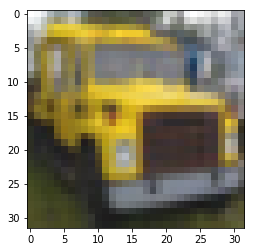

Predicted class truck with confidence 0.916817
delta t: 0.000630


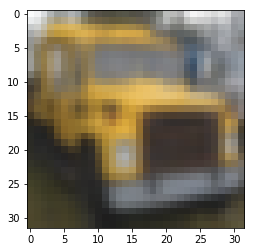

Predicted class truck with confidence 0.686655


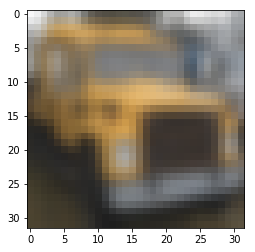

Predicted class deer with confidence 0.910602


In [7]:
# showing the effect of gaussian filtering at different std values on an example image

idx = 335
plt.imshow(x_test[idx])
plt.show()
predictions = model.predict(np.tile(x_test[idx],[1,1,1,1]))
print("Predicted class %s with confidence %f" % (classes[predictions.argmax()], predictions.max()))

t0 = time.time()
sig6 = ndimage.gaussian_filter(x_test[idx], sigma=.6)
t1 = time.time()
print("delta t: %f" % (t1-t0))
plt.imshow(sig6)
plt.show()
predictions = model.predict(np.tile(sig6,[1,1,1,1]))
print("Predicted class %s with confidence %f" % (classes[predictions.argmax()], predictions.max()))

sig8 = ndimage.gaussian_filter(x_test[idx], sigma=.8)
plt.imshow(sig8)
plt.show()
predictions = model.predict(np.tile(sig8,[1,1,1,1]))
print("Predicted class %s with confidence %f" % (classes[predictions.argmax()], predictions.max()))


In [8]:
# applying gaussian filtering at various std values to the CIFAR10 test set and the adversarial CIFAR10 test set

x_test_adv_filtered = np.zeros([7, 10000, 32, 32, 3])
x_test_filtered = np.zeros([7, 10000, 32, 32, 3])

for i in range(10000):
    x_test_adv_filtered[0][i] = ndimage.gaussian_filter(x_test_adv[i], sigma=.2)
    x_test_filtered[0][i] = ndimage.gaussian_filter(x_test[i], sigma=.2)
    
    x_test_adv_filtered[1][i] = ndimage.gaussian_filter(x_test_adv[i], sigma=.3)
    x_test_filtered[1][i] = ndimage.gaussian_filter(x_test[i], sigma=.3)
    
    x_test_adv_filtered[2][i] = ndimage.gaussian_filter(x_test_adv[i], sigma=.4)
    x_test_filtered[2][i] = ndimage.gaussian_filter(x_test[i], sigma=.4)
    
    x_test_adv_filtered[3][i] = ndimage.gaussian_filter(x_test_adv[i], sigma=.5)
    x_test_filtered[3][i] = ndimage.gaussian_filter(x_test[i], sigma=.5)
    
    x_test_adv_filtered[4][i] = ndimage.gaussian_filter(x_test_adv[i], sigma=.6)
    x_test_filtered[4][i] = ndimage.gaussian_filter(x_test[i], sigma=.6)
    
    x_test_adv_filtered[5][i] = ndimage.gaussian_filter(x_test_adv[i], sigma=.7)
    x_test_filtered[5][i] = ndimage.gaussian_filter(x_test[i], sigma=.7)
    
    x_test_adv_filtered[6][i] = ndimage.gaussian_filter(x_test_adv[i], sigma=.8)
    x_test_filtered[6][i] = ndimage.gaussian_filter(x_test[i], sigma=.8)

In [9]:
# testing filtered test set and filtered adversarial test set on both the regular and adversarially trained CNN's

for i in range(7):
    print("\nUnaltered+filtered test set evaluation")
    scores = model.evaluate(x_test_filtered[i], y_test, verbose=1)
    scores_adv = model_adv.evaluate(x_test_filtered[i], y_test, verbose=1)
    print('Original model test accuracy:', scores[1])
    print('Retrained model test accuracy:', scores_adv[1])
    print('Original model test loss:', scores[0])
    print('Retrained model test loss:', scores_adv[0])

for i in range(7):
    print("\nAdversarial+filtered test set evaluation")
    scores = model.evaluate(x_test_adv_filtered[i], y_test_adv, verbose=1)
    scores_adv = model_adv.evaluate(x_test_adv_filtered[i], y_test_adv, verbose=1)
    print('Original model test accuracy:', scores[1])
    print('Retrained model test accuracy:', scores_adv[1])
    print('Original model test loss:', scores[0])
    print('Retrained model test loss:', scores_adv[0])


Unaltered+filtered test set evaluation
10000/10000 [==============================] - 1s 128us/step
Original model test accuracy: 0.7545
Retrained model test accuracy: 0.7685
Original model test loss: 0.7729540209770203
Retrained model test loss: 0.6886908890724183

Unaltered+filtered test set evaluation
10000/10000 [==============================] - 1s 127us/step
Original model test accuracy: 0.7574
Retrained model test accuracy: 0.7672
Original model test loss: 0.7678047375679016
Retrained model test loss: 0.6895526030540466

Unaltered+filtered test set evaluation
10000/10000 [==============================] - 1s 127us/step
Original model test accuracy: 0.768
Retrained model test accuracy: 0.7622
Original model test loss: 0.7292801014900208
Retrained model test loss: 0.7111359392166138

Unaltered+filtered test set evaluation
10000/10000 [==============================] - 1s 126us/step
Original model test accuracy: 0.7686
Retrained model test accuracy: 0.719
Original model test loss:

ValueError: Input arrays should have the same number of samples as target arrays. Found 10000 input samples and 50000 target samples.